In [1]:
import bhnerf
from astropy import units
import jax

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from flax.training import checkpoints
from pathlib import Path
import ruamel.yaml as yaml
import warnings
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib import animation

os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
warnings.simplefilter("ignore")

Welcome to eht-imaging! v 1.2.5 



In [5]:
def animate(movie, t_frames=None, fps=10, output=None, writer='ffmpeg'):

    # Image animation function (called sequentially)
    def animate_frame(i):
        if t_frames is not None:
            axes.set_title('t={:1.2f} UTC'.format(t_frames[i]))
        im.set_array(movie[i])
        return im
    
    num_frames = movie.shape[0]
    
    fig, axes = plt.subplots(1,1, figsize=(4,4))
    im =  axes.imshow(movie[0])
    if t_frames is not None:
        axes.set_title('t={:1.2f} UTC'.format(t_frames[0]), fontsize=16)
    axes.set_axis_off()
    
    plt.tight_layout()
    anim = animation.FuncAnimation(fig, animate_frame, frames=num_frames, interval=1e3 / fps)

    if output is not None:
        anim.save(output, writer=writer, fps=fps)
    return anim

def render_mean_images(seeds, inclinations, t_frames, t_start_obs, norm_const, fov, bh_radius, view_zeniths, 
                       view_azimuths, resolution, cam_r, linewidth, chunk=32, jit=False):
    
    rot_sign = {'cw': -1, 'ccw': 1}
    images = []
    seeds = np.atleast_1d(seeds)
    inclinations = np.atleast_1d(inclinations)
    visualizer = bhnerf.visualization.VolumeVisualizer(resolution, resolution, resolution)
    for zenith in tqdm(np.atleast_1d(view_zeniths), desc='view zenith', leave=False):
        for azimuth in tqdm(np.atleast_1d(view_azimuths), desc='view azimtuh', leave=False):
            for t in tqdm(np.atleast_1d(t_frames), desc='t', leave=False):
                emission = 0
                visualizer.set_view(cam_r=cam_r, domain_r=fov/2.0, azimuth=azimuth, zenith=zenith)
               
                # Keplerian velocity
                if t != t_start_obs:
                    r = np.sqrt(visualizer.coords[0]**2 + visualizer.coords[1]**2 + visualizer.coords[2]**2)
                    Omega = rot_sign[Omega_dir] * np.sqrt(1) / (r**(3/2) + spin * np.sqrt(1))
                else:
                    Omega = 0.0

                for inc in tqdm(inclinations, desc='inc', leave=False):
                    for seed in tqdm(seeds, desc='seed', leave=False):
                        checkpoint_dir = recovery_path.joinpath(basename.format(inc, seed))
                        emission += (1/(len(seeds)*len(inclinations))) * bhnerf.network.sample_checkpoint_3d(
                            checkpoint_dir, t, t_start_obs, Omega, coords=visualizer.coords, chunk=chunk
                        )
                    
                image = visualizer.render(emission / norm_const, facewidth=1.9*fov/2.0, jit=jit, bh_radius=bh_radius, linewidth=linewidth).clip(max=1)
                images.append(image)
    return images

In [14]:
basename = 'inc_{:.1f}.seed_{}'
recovery_path = Path('../checkpoints/alma/intrinsic_fits/vertical_b_variable_pixels1/')
outpath = Path(os.path.join(*recovery_path.parts[2:]))
outpath.mkdir(parents=True, exist_ok=True)

with open(recovery_path.joinpath('config.yml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

locals().update(config['preprocess'])
locals().update(config['model'])
train_split = config['optimization']['train_split']
sigma = config['optimization']['sigma']

# Preprocess / split data to train/validation
target, t_frames = bhnerf.alma.preprocess_data(**config['preprocess'])
train_idx = t_frames <= t_start*units.hr + train_split*units.min
t_train, data_train  = t_frames[train_idx], target[train_idx]

# Rotate 3D volume
---
Rotate the recovered initial (canonical) 3D volume

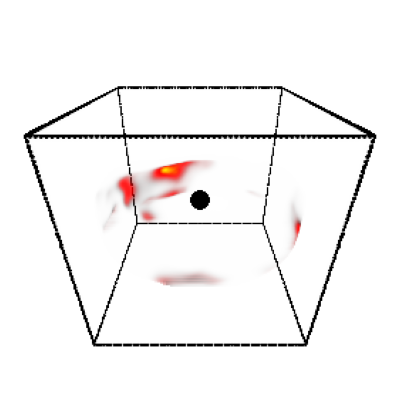

In [88]:
seeds = range(5)
inclinations = 12

renderer_params = {
    'resolution': 256,
    'cam_r': 55.,
    'fov': fov_M,
    'linewidth': 0.14,
    'norm_const': 0.05,
    'bh_radius': 1 + np.sqrt(1-spin**2),
    't_frames': 0,
    't_start_obs': 0,
    'view_zeniths': np.deg2rad(60),
    'view_azimuths': np.linspace(0, 2*np.pi, 30)
}

images = render_mean_images(seeds, inclinations, **renderer_params, jit=True)

outformat = '3D_recovery_animation_rot_zenith_{:2d}_seeds_{}_incs_{}'
outname = outformat.format(
    int(np.round(np.rad2deg(renderer_params['view_zeniths']))),
    '-'.join([str(seed) for seed in np.atleast_1d(seeds)]),
    '-'.join([str(int(inc)) for inc in np.atleast_1d(inclinations)])
)
np.save(outpath.joinpath(outname +'.npy'), np.array(images))

%matplotlib widget
animate(movie, output=outpath.joinpath(outname +'.gif'))

# Animate evolution
---
Animate the recovered 3D volume according to a Keplerian orbit

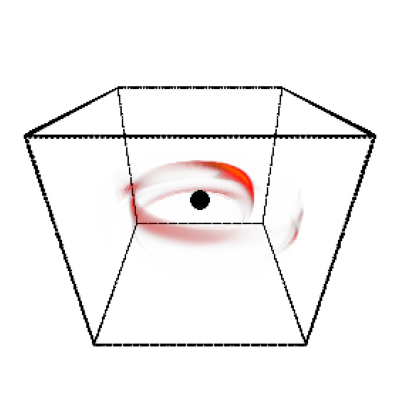

In [10]:
seeds = range(5)
inclinations = 12

renderer_params = {
    'resolution': 256,
    'cam_r': 55.,
    'fov': fov_M,
    'linewidth': 0.14,
    'norm_const': 0.05,
    'bh_radius': 1 + np.sqrt(1-spin**2),
    't_frames': np.linspace(t_train[0], t_train[-1], 100),
    't_start_obs': t_start_obs,
    'view_zeniths': np.deg2rad(30),
    'view_azimuths': 0.0
    
}

images = render_mean_images(seeds, inclinations, **renderer_params, jit=True)
movie = np.array(images)

outformat = '3D_recovery_animation_evolution_{:2d}_seeds_{}_incs_{}'
outname = outformat.format(
    int(np.round(np.rad2deg(renderer_params['view_zeniths']))),
    '-'.join([str(seed) for seed in np.atleast_1d(seeds)]),
    '-'.join([str(int(inc)) for inc in np.atleast_1d(inclinations)])
)
np.save(outpath.joinpath(outname +'.npy'), movie)

%matplotlib widget
animate(movie, output=outpath.joinpath(outname +'.gif'))